In [70]:
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import triangulate
import shapely.wkt
import pandas as pd
import geopandas as gpd
from geovoronoi import voronoi_regions_from_coords

def to_triangles(polygon):

    poly_points = []

    gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
    for geom in gdf_poly_exterior.geometry:
        poly_points += np.array(geom.coords).tolist()

    try:
        polygon.interiors[0]
    except:
        poly_points = poly_points
    else:
        gdf_poly_interior = gpd.GeoDataFrame({'geometry': [polygon.interiors]}).explode().reset_index()
        for geom in gdf_poly_interior.geometry:
          poly_points += np.array(geom.coords).tolist()

    poly_points = np.array([item for sublist in poly_points for item in sublist]).reshape(-1,2)

    poly_shapes, pts = voronoi_regions_from_coords(poly_points, polygon)
    gdf_poly_voronoi = gpd.GeoDataFrame({'geometry': poly_shapes}).explode().reset_index()

    tri_geom = []
    for geom in gdf_poly_voronoi.geometry:
        inside_triangles = [tri for tri in triangulate(geom) if tri.centroid.within(polygon)]
        tri_geom += inside_triangles

    gdf_poly_triangles = gpd.GeoDataFrame({'geometry': tri_geom}, crs=4326)

    return gdf_poly_triangles
poly_input = gpd.read_file("scenarios/kildare/kildare.geojson")['geometry'][0]

poly_tri_4326 = to_triangles(poly_input)
poly_tri_3857 = poly_tri_4326.to_crs('EPSG:3857')

print(poly_tri_3857['geometry'][0])

C:\Users\Paddy\AppData\Local\Temp\ipykernel_26500\3065602740.py:13: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf_poly_exterior = gpd.GeoDataFrame({'geometry': [polygon.buffer(-0.1).exterior]}).explode().reset_index()
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
c:\Users\Paddy\miniconda3\envs\radian\Li

POLYGON ((-781070.0309129261 7020168.327962863, -774670.3284308267 7006012.894004469, -773214.4443205724 7005752.4328272315, -781070.0309129261 7020168.327962863))


Now we have chosen our triangle. How do we go about generating a random point inside of it? Alpha Wolfram has a great post about this. The gist of it: We assume one point of the triangle to be at the origin of our coordinate system [0, 0]. For the other two points we create two random weights in the range of [0, 1]. We multiply (scale) each point by one of the weights and add both points up. Tada random points!

Original gen from wolframalpha explanation, limiting points in the triangle comes from the Points with Triangulation paper


AttributeError: 'list' object has no attribute 'plot'

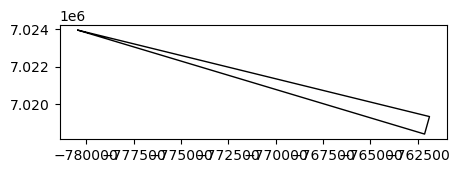

In [87]:
import random
import matplotlib.pyplot as plt

def points_in_triangle(poly_tri, points):
    v1, v2, v3 = poly_tri.exterior.coords[0:3]
    v2_scaled = [v2[0] - v1[0], v2[1] - v1[1]]
    v3_scaled = [v3[0] - v1[0], v3[1] - v1[1]]
    
    points_list = []
    for i in range(points):
        s, t = random.uniform(0,1), random.uniform(0,1)
        if s+t > 1:
            s = 1 - s
            t = 1 - t
        two_weighted = [v2_scaled[0] * s, v2_scaled[1] * s]
        three_weighted = [v3_scaled[0] * t, v3_scaled[1] * t]

        new_point = np.add(np.add(two_weighted, three_weighted), [v1[0], v1[1]])
        points_list.append(shapely.Point(new_point))
    
    full_gdf = gpd.GeoDataFrame(pd.DataFrame(points_list, columns=['geometry']), geometry='geometry')

    return points_list#full_gdf

tri_simple = gpd.GeoSeries(shapely.Polygon([(0,0), (0.5,1), (1,0)]))

tri_test = gpd.GeoSeries(poly_tri_3857['geometry'][5])

#new_points = points_in_triangle(tri_simple.iloc[0], 100)
new_points = points_in_triangle(tri_test.iloc[0], 100)


fig, ax = plt.subplots(figsize=(5,5))

tri_test.plot(ax=ax, facecolor='none', edgecolor='black')
new_points.plot(ax=ax)

In [110]:
# getting a distribution from the triangles based on area
print(poly_tri_3857['geometry'].area)

def area_dist(polys):
    total_area = sum(polys.area)
    cum_dist = []
    for i, poly in enumerate(polys):
        if i > 0:
            last_value = cum_dist[i-1]
        else:
            last_value = 0
        cum_dist.append(last_value + (poly.area / total_area))
    
    return cum_dist

def random_poly(polys):
    cum_dist = area_dist(polys)
    rand = random.random()
    index = cum_dist.index(next(x for x in cum_dist if x > rand), 0)
    return polys[index]

random_poly(poly_tri_3857['geometry'])

0      9.470899e+06
1      1.209370e+07
2      2.080839e+05
3      1.398552e+05
4      1.955750e+07
           ...     
466    2.636645e-02
467    1.069800e-02
468    5.184329e-03
469    5.019634e+06
470    1.166680e+07
Length: 471, dtype: float64
POLYGON ((-764693.8411000178 7010403.011517897, -761401.8807728654 7004885.800872251, -749082.8771947268 6996128.324885609, -764693.8411000178 7010403.011517897))


471


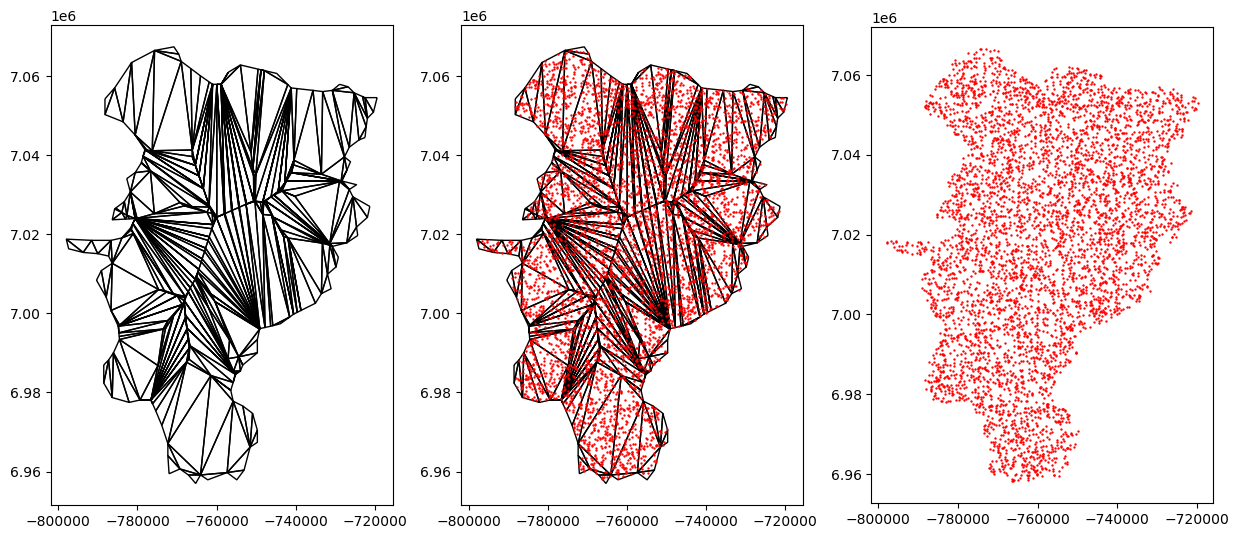

Time taken for generation:  12.72302508354187


In [114]:
import time

triangle_points = []

start_time = time.time()

print(len(poly_tri_3857['geometry']))

num_tri = len(poly_tri_3857['geometry'])
points_goal = 5000

for i in range(points_goal):
    tri = random_poly(poly_tri_3857['geometry'])
    #j = random.randint(0,num_tri-1)
    #tri = poly_tri_3857['geometry'][j]
    x = points_in_triangle(tri, 1)
    triangle_points += x

triangle_points = gpd.GeoDataFrame(pd.DataFrame(triangle_points, columns=['geometry']), geometry='geometry')
end_time = time.time()

fig, ax = plt.subplots(1,3, figsize=(15,10))

poly_tri_3857.plot(ax=ax[0], facecolor='none', edgecolor='black')

poly_tri_3857.plot(ax=ax[1], facecolor='none', edgecolor='black')
triangle_points.plot(ax=ax[1], color='red', markersize=0.5)

triangle_points.plot(ax=ax[2], color='red', markersize=0.5)

plt.show()

print("Time taken for generation: ", end_time - start_time)